<a href="https://colab.research.google.com/github/arthurw74/DeepFake/blob/master/Deep_Fake_passo_a_passo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep fake

Infelizmente deep fake tem um potencial destrutivo. meu warning é importante. Você pode usar este notebook apenas com imagens de quem te deu autorização explícita para fazer os testes de deep fake, sem exceção. Grandes poderes, grandes responsabilidades. Queremos informar, ensinar, aprender.

Caso forke esse notebook, siga as regras de uso.



Automatizado por Guilherme Silveira, https://twitter.com/guilhermecaelum

Original de https://colab.research.google.com/github/AliaksandrSiarohin/first-order-model/blob/master/demo.ipynb "First Order Motion Model for Image Animation"


### PASSO 1

Se cadastre e baixe o arquivo vox-cpk.pth.tar se cadastrando aqui e baixando https://yadi.sk/d/lEw8uRm140L_eQ
Ou então em https://mega.nz/file/59JknSyY#R1jZr0MIb8rfpoQCX787AVcUPT96uTpfA5GdlrpL7vM

### PASSO 2

Crie um diretório chamado `deepfake` no seu google drive.

Coloque lá:
- uma imagem com `nome.png`
- o vídeo com `nome.mp4`
- o arquivo `vox-cpk.pth.tar`

### PASSO 3

In [1]:
# coloque aqui o nome do arquivo da sua imagem e a extensão

base_name = "doll-06"
image_extension = "png"

### PASSO 4

In [2]:
# PASSO 4

# corrija o corte do vídeo de origem. rode uma vez assim, depois vá atualizando

# assumindo que o vídeo é 1920 x 1080
# o rosto da pessoa está na parte "de baixo" do vídeo

DIMENSION = 1080
MIN_X = 0
MIN_Y = 640

should_crop = True

### PASSO 5: Autorize o google colab para acessar o google drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Setup de diretórios

**Git clone**

In [4]:
!git clone https://github.com/AliaksandrSiarohin/first-order-model

Cloning into 'first-order-model'...
remote: Enumerating objects: 293, done.
remote: Total 293 (delta 0), reused 0 (delta 0), pack-reused 293
Receiving objects: 100% (293/293), 72.14 MiB | 32.40 MiB/s, done.
Resolving deltas: 100% (151/151), done.


In [5]:
cd first-order-model

/content/first-order-model


# Pequenas alterações no vídeo original

In [6]:
movie_input = 'tete'
movie_original = f"/content/gdrive/My Drive/deepfake/{movie_input}.mp4"

In [7]:
input = base_name
image_output = f"/content/gdrive/My Drive/deepfake/{input}-256.png"

## Conferindo dimensões

In [8]:
import warnings


warnings.filterwarnings("ignore")

(0.0, 16.0, 998.0, 1014.0)
Oh, a imagem que você pegou não é quadrada, cortando o meio... 998 x 1030
(998, 998)
(256, 256)


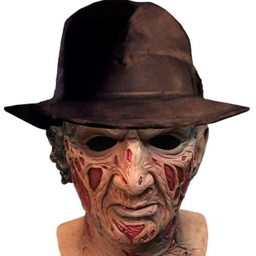

In [9]:
from PIL import Image


im = Image.open(f"/content/gdrive/My Drive/deepfake/{input}.{image_extension}")
width, height = im.size

if width != height:
  new_size = min(width, height)
  left = (width - new_size)/2
  top = (height - new_size)/2
  right = (width + new_size)/2
  bottom = (height + new_size)/2

  cut = (left, top, right, bottom)
  print(cut)
  im = im.crop(cut)
  print(f"Oh, a imagem que você pegou não é quadrada, cortando o meio... {width} x {height}")


if width < 256:
  raise Exception(f"Oh, a imagem que você pegou é pequena, vai zoar! {width}")

print(im.size)
im.thumbnail((256, 256))
print(im.size)
im.save(image_output)
display(im)

In [10]:

import os
import shutil
from moviepy.editor import VideoFileClip

movie_source = "../movie_quadrado.mp4"

if should_crop:
  !ffmpeg -y -hide_banner -loglevel warning -i "$movie_original" -filter:v 'crop={DIMENSION}:{DIMENSION}:{MIN_X}:{MIN_Y}' "$movie_source"
else:
  shutil.copyfile(movie_original, movie_source)


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1236992/45929032 bytes (2.7%)3825664/45929032 bytes (8.3%)7348224/45929032 bytes (16.0%)10969088/45929032 bytes (23.9%)14934016/45929032 bytes (32.5%)18497536/45929032 bytes (40.3%)22347776/45929032 bytes (48.7%)26271744/45929032 bytes (57.2%)30244864/45929032 bytes (65.9%)34258944/45929032 bytes (74.6%)38035456/45929032 bytes (82.8%)41959424/45929032 bytes (91.4%)4

In [11]:
from moviepy.editor import ipython_display


ipython_display(movie_source, width=256)

## Gerando mp3 e alterando tamanhos

In [12]:
generated_audio = f"../generated_audio_{base_name}.mp3"
!ffmpeg -y -hide_banner -loglevel warning -i "$movie_original" -vn -ar 44100 -ac 2 -ab 192k -f mp3 "$generated_audio"


In [13]:
import imageio
from skimage.transform import resize
from tqdm.notebook import trange, tqdm

source_image = imageio.imread(image_output)
driving_video = imageio.mimread(movie_source, memtest=False)

source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in tqdm(driving_video, desc="video resize")]


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


def display_side_by_side(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in tqdm(range(len(driving)), "generating slides"):
        cols = [source]
        cols.append(driving[i])
        if generated:
        # if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat=False)
    plt.close()
    return HTML(ani.to_html5_video())


display_side_by_side(source_image, driving_video)

# O deepfake

In [15]:
# se a célula a seguir não funcionar, descomente a linha a seguir
# por exemplo, se você usa o google colab pro, você talvez
# tenha que definir qual device de GPU será utilizado, por isso ;)\\\\\


CUDA_VISIBLE_DEVICES=0

In [16]:
# Outro possível problema
# Caso você não tenha o GPU ativado por padrão, você pode ir no menu Runtime > Change runtime type > GPU

# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

In [17]:
from demo import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', 
                            checkpoint_path='/content/gdrive/My Drive/deepfake/vox-cpk.pth.tar')

## Animando

In [18]:
from demo import make_animation
from skimage import img_as_ubyte
from skimage.io import concatenate_images

predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

display_side_by_side(source_image, driving_video, predictions)

100%|██████████| 230/230 [00:08<00:00, 26.23it/s]


In [ ]:
def frames_to_frame(f1, f2,f3):
  return np.concatenate((f1, np.array(f2), np.array(f3)),axis=1)

In [ ]:
imageio.mimsave('../generated.mp4', [img_as_ubyte(frames_to_frame(source_image,f2,f3)) for f2,f3 in tqdm(zip(driving_video, predictions), desc="concatenating frames")])

display_side_by_side(source_image, driving_video, predictions)

In [ ]:
from google.colab import files

# files.download('../generated.mp4') 
ipython_display("../generated.mp4")

## Definindo a velocidade

In [ ]:
from moviepy.editor import VideoFileClip
generated_duration = VideoFileClip("../generated.mp4").duration
original_duration = VideoFileClip(movie_source).duration
multiple = generated_duration / original_duration
print( generated_duration, original_duration, multiple )

23.0 7.68 2.994791666666667


## O vídeo final

In [ ]:
setpts = f'setpts=PTS/{multiple}'
!ffmpeg -y -hide_banner -loglevel warning -i "../generated.mp4" -filter:v $setpts "../generated_speed_control.mp4"
print(f"Colocando o áudio")

final_name = f"../generated_final_{base_name}.mp4"
!ffmpeg -y -hide_banner -loglevel warning -i "../generated_speed_control.mp4" -i $generated_audio -c:v copy -c:a aac $final_name

ipython_display(final_name)

Past duration 0.666985 too large
Colocando o áudio


## Demonstração de keypoint relativos

Estilo de cabelo etc serão copiados

In [ ]:
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=False, adapt_movement_scale=True)
display_side_by_side(source_image, driving_video, predictions)


final = f"../generated_final_{base_name}.mp4"
!ffmpeg -y -hide_banner -loglevel warning -i "../generated_speed_control.mp4" -i $generated_audio -c:v copy -c:a aac $final

100%|██████████| 230/230 [00:08<00:00, 25.59it/s]


## Download

In [ ]:
files.download(predictions)



TypeError: ignored